In [11]:
!pwd
!ls -lah

/Users/drbh/Documents/00000/SpeakerDetectionRecog/speaker_detection
total 35232
drwxr-xr-x  31 drbh  staff   1.0K Jan 10 16:39 .
drwxr-xr-x   7 drbh  staff   238B Jan  2 16:43 ..
-rw-r--r--@  1 drbh  staff    10K Jan  3 14:48 .DS_Store
drwxr-xr-x   8 drbh  staff   272B Jan 10 16:35 .ipynb_checkpoints
drwxr-xr-x  11 drbh  staff   374B Jan  2 16:45 People
-rw-r--r--   1 drbh  staff   3.0K Dec 28 12:10 Radio Streaming.ipynb
-rw-r--r--   1 drbh  staff    20K Jan 10 16:39 Untitled.ipynb
-rw-r--r--   1 drbh  staff   1.6K Dec 26 21:18 Untitled1.ipynb
-rw-r--r--   1 drbh  staff    16K Dec 28 17:11 add_user.ipynb
-rw-r--r--   1 drbh  staff   344K Dec 28 12:16 apt.wav
-rw-r--r--   1 drbh  staff   1.0K Dec 29 00:31 audios.py
-rw-r--r--   1 drbh  staff   513K Jan 10 15:23 base_silence.wav
drwxr-xr-x@  6 drbh  staff   204B Nov 14 18:39 data
drwxr-xr-x@ 12 drbh  staff   408B Dec 25 16:25 feature
drwxr-xr-x@ 14 drbh  staff   476B Dec 26 18:27 filters
drwxr-xr-x@ 16 drbh  staff   544B Dec 25 16:32 gmm

In [1]:
from collections import defaultdict
from scipy.io import wavfile
import numpy as np
import cPickle as pickle
import traceback as tb
import itertools
import glob
import time
import os
import sys

# add to run in ipython
sys.path.append('./gui/')

from interface import ModelInterface
from utils import read_wav
from filters.silence import remove_silence
from feature import mix_feature

No module named ap


In [8]:
execfile("./audios.py")

In [3]:
import boto3


In [6]:
event = {
  "Records": [
    {
      "eventVersion": "2.0",
      "eventTime": "1970-01-01T00:00:00.000Z",
      "requestParameters": {
        "sourceIPAddress": "127.0.0.1"
      },
      "s3": {
        "configurationId": "testConfigRule",
        "object": {
          "key": "03_my_name.wav"
        },
        "bucket": {
          "name": "asu.datascience"
        },
        "s3SchemaVersion": "1.0"
      },
      "eventSource": "aws:s3"
    }
  ]
}

In [26]:
import json
import urllib
s3 = boto3.client('s3')
bucket = event['Records'][0]['s3']['bucket']['name']
key = urllib.unquote_plus(event['Records'][0]['s3']['object']['key'].encode('utf8'))
print "Getting file:", key, "from bucket", bucket
s3.download_file(bucket, key, '/tmp/temp.wav')
os.path.exists("/tmp/temp.wav")
print "File saved to: /tmp/temp.wav"

Getting file: 03_my_name.wav from bucket asu.datascience
File saved to: /tmp/temp.wav


True

In [3]:
def record_samples(name, n = 20):
    for i in range(1,n):
        dirc = "./People/" + name + "/"
        fname = time.strftime("%Y%m%d-%H%M%S") 
        print(i)
        record_audio( dirc + fname + ".wav")
    print("done")
    
def see_model(mods):
    for count, (key, value) in enumerate(mods.features.iteritems(), 1):
        print count, key, len(value)
        
def add_user_to_model(model,name):
    m = model
    fname = "./People/" + name + "/"
    input_dirs = fname
    input_dirs = [os.path.expanduser(k) for k in input_dirs.strip().split()]
    dirs = itertools.chain(*(glob.glob(d) for d in input_dirs))
    dirs = [d for d in dirs if os.path.isdir(d)]
    files = []
    print(dirs)
    if len(dirs) == 0:
        print "No valid directory found!"
        sys.exit(1)
    for d in dirs:
        label = os.path.basename(d.rstrip('/'))

        wavs = glob.glob(d + '/*.wav')
        if len(wavs) == 0:
            print "No wav file found in {0}".format(d)
            continue
        print "Label {0} has files {1}".format(label, ','.join(wavs))
        for wav in wavs:
            fs, signal = read_wav(wav)
#             fs, signal = check_vad(fs, signal)
            if len(signal) > 0:
                m.enroll(label, fs, signal)
    m.train()
    
def record_samples(name, n = 20):
    for i in range(1,n):
        dirc = "./People/" + name + "/"
        fname = time.strftime("%Y%m%d-%H%M%S") 
        print(i)
        record_audio( dirc + fname + ".wav")
    print("done")

def test_model(mods,path = "./tmp.wav"):
    fs, signal = read_wav(path)
    feat = mix_feature((fs, signal))
    x = feat
    scores = [mods.gmmset.gmm_score(gmm, x) / len(x) for gmm in mods.gmmset.gmms]
    import operator
    p = sorted(enumerate(scores), key=operator.itemgetter(1), reverse=True)
    p = [(str(mods.gmmset.y[i]), y, p[0][1] - y) for i, y in p]
    result = [(mods.gmmset.y[index], value) for (index, value) in enumerate(scores)]
    p = max(result, key=operator.itemgetter(1))
    return result
    
def find_user():
    #print(" + Recording")
    record_audio("./tmp.wav")
    #print(" + Predicting")
    input_model = "model.out"
    input_files = "./tmp.wav"
    m = ModelInterface.load(input_model)
#     m = model
    for f in glob.glob(os.path.expanduser(input_files)):
        fs, signal = read_wav(f)
        label = m.predict(fs, signal)
        print max(label, key=operator.itemgetter(1))
#         if abs(label[0][1] - label[1][1]) > .0000002:
#             speakers_detected = [x for x in label if x[1] >= -.1]
#             if len(speakers_detected) > 0:
#                 print max(speakers_detected, key=operator.itemgetter(1))
#             else:
#                 print "___                         not similar enough to know speaker"
#         else:
#             print "...                                    predictions too similar"

    

In [4]:
mods = ModelInterface()

In [7]:
def set_baseline_noise(mods):
    record_audio("base_silence.wav")
    fs, signal = read_wav("base_silence.wav")
    return mods.init_noise(fs, signal)

set_baseline_noise(mods)

max_ltsd = 18.609011273
lambda0 = 20.4699124004
lambda1 = 40.9398248007


In [6]:
mods = mods.load("./model.out")
see_model(mods)

1 Kathy 2775
2 Luke 2775
3 David 3515
4 Nick 2590
5 Joe 2405
6 Lauren 2405


In [14]:

directory = "./People/New"
if not os.path.exists(directory):
    os.makedirs(directory)
else:
    print "already made"
    
record_samples("New")

already made
1
2


KeyboardInterrupt: 

In [15]:
add_user_to_model(mods,"New")
see_model(mods)
    

['./People/New/']
Label New has files ./People/New/20170116-133231.wav,./People/New/20170116-133233.wav,./People/New/20170116-133234.wav,./People/New/20170116-133235.wav,./People/New/20170116-133237.wav,./People/New/20170116-133238.wav,./People/New/20170116-133240.wav,./People/New/20170116-133241.wav,./People/New/20170116-133242.wav,./People/New/20170116-133244.wav,./People/New/20170116-133245.wav,./People/New/20170116-133246.wav,./People/New/20170116-133333.wav
Start training...
7.70209598541  seconds
1 Kathy 2775
2 Luke 2775
3 David 3515
4 Nick 2590
5 Joe 2405
6 New 1900
7 Lauren 2405


In [16]:
def check_vad(fs,signal):
    new_signal = mods.filter(*(fs, signal))
    print "After removed: {0} -> {1}".format(len((fs, signal)[1]), len(new_signal))
    print "Enroll: {:.4f} seconds".format(float(len(new_signal)) / fs)
    if len(new_signal) == 0:
        print "Error! Input is silent! Please enroll again"
    return (fs,new_signal)

['./People/New/']
Label New has files ./People/New/20170116-133231.wav,./People/New/20170116-133233.wav,./People/New/20170116-133234.wav,./People/New/20170116-133235.wav,./People/New/20170116-133237.wav,./People/New/20170116-133238.wav,./People/New/20170116-133240.wav,./People/New/20170116-133241.wav,./People/New/20170116-133242.wav,./People/New/20170116-133244.wav,./People/New/20170116-133245.wav,./People/New/20170116-133246.wav
Start training...
7.59314584732  seconds


1 Kathy 2775
2 Luke 2775
3 David 3515
4 Nick 2590
5 Joe 2405
6 New 912
7 Lauren 2405


In [19]:
mods.dump("model.out")

In [9]:
import operator
execfile("./audios.py")
for i in range(1,60):
    find_user()

('David', -0.468528510096478)
('David', -0.38083417879766585)
('David', -0.37572212556539331)
('Luke', -0.36622744808001945)
('David', -0.29201383636938133)
('David', -0.31291997505962793)
('David', -0.23317528882797384)
('David', -0.45305351562237645)
('David', -0.30733288479169379)
('David', -0.37466500055964314)
('David', -0.32054089580694139)
('David', -0.25519878307155153)
('David', -0.32568186373950025)
('David', -0.33022444290998548)
('David', -0.31753966972521142)
('David', -0.65032151036882346)
('David', -0.33933075840462301)
('David', -0.47221432459368284)
('David', -0.25315117733737208)
('David', -0.28802322257623908)
('David', -0.40359549199675426)
('Luke', -0.47630632540979118)
('David', -0.52306164329043836)
('Luke', -0.49331363359889696)
('Luke', -0.41014341974346163)
('Luke', -0.51646021542978438)
('Nick', -0.42163031263679768)
('David', -0.44938054705096941)
('David', -0.27054171506423669)
('David', -0.37225037582665432)
('David', -0.45153437498501275)


KeyboardInterrupt: 

# Editing things below

In [18]:
test_model(mods)

[('Kathy', -0.20554578130567816),
 ('Joe', -0.15968625310309717),
 ('David', -0.11703955291437099)]

In [19]:
#save model after interaction
mods.dump("./model_cleaned.out")

In [20]:
import requests
import pydub

def open_radio():
    stream_url = 'https://fm939.wnyc.org/wnycfm'
    r = requests.get(stream_url, stream=True)
    return r

def stream_sample(r):
    a = 0
    with open('stream.mp3', 'wb') as f:
        for block in r.iter_content(1024):
            f.write(block)
            a = a + 1
            if ( a > 100):
                break
        r.close()     
    sound = pydub.AudioSegment.from_mp3("stream.mp3")
    sound.export("stream.wav", format="wav")

In [25]:
radio_stream = open_radio()

In [24]:
stream_sample(radio_stream)

AttributeError: 'NoneType' object has no attribute 'read'

In [32]:
test_model(mods,path="/Users/drbh/speaker_detection/stream.wav")

[('Kathy', -0.22063075609044483),
 ('Joe', -0.32511116851104532),
 ('David', -0.20578142969093302)]

In [38]:
test_model(mods,path="/Users/drbh/speaker_detection/stream.wav")

[('Kathy', -0.22063075609044483),
 ('Joe', -0.32511116851104532),
 ('David', -0.20578142969093302)]

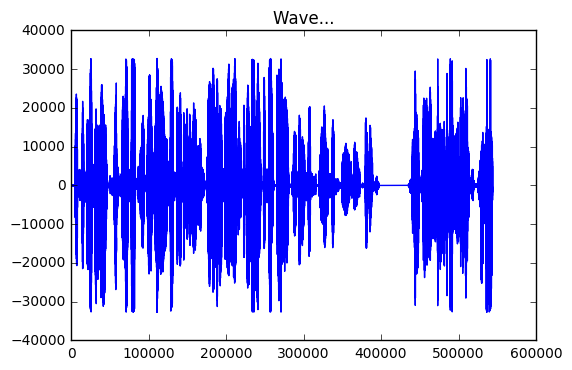

In [517]:
spf = wave.open('/Users/drbh/speaker_detection/stream.wav','r')
fs = spf.getframerate()
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16') * 3
plot_wav(signal)

In [72]:
check_vad(fs, signal)

[(5120, 48128), (51200, 92160), (93184, 146432), (147456, 150528), (151552, 169984), (172032, 248832), (249856, 282624), (285696, 318464), (321536, 340992), (388096, 392192), (437248, 478208), (479232, 497664), (498688, 516096), (521216, 537600)] 542720
After removed: 543744 -> 417792
Enroll: 13.0560 seconds


(32000, array([ -15,  -15,  -12, ..., 2232, 2109, 2031], dtype=int16))

In [79]:
xyz = ModelInterface()

In [82]:
xyz.enroll("Unknown", fs, signal)
xyz.train()

Start training...
0.243736982346  seconds


In [84]:
see_model(xyz)

1 Unknown 3183


In [88]:
test_model(xyz,path="/Users/drbh/speaker_detection/stream.wav")

[('Unknown', -0.5572814200302002)]

In [63]:
print signal.mean()
print signal.max()
print signal.min()
print signal.sum()

-0.185640669138
15674
-12064
-100941


In [58]:
spf = wave.open('/Users/drbh/speaker_detection/People/David/20161228-214054.wav','r')
fs = spf.getframerate()
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')
check_vad(fs, signal)

[(5120, 519168)] 524288
After removed: 525600 -> 514048
Enroll: 11.6564 seconds


(44100,
 array([-16478,     62, -16479, ...,   -672, -12532,   -672], dtype=int16))

In [59]:
print signal.mean()
print signal.max()
print signal.min()
print signal.sum()

-103.23598554
32767
-32768
-54260834


In [520]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys


def plot_wav(signal):
    plt.title('Wave...')
    plt.plot(signal)
    
def subst_wav(fs, signal, start=1000,seconds=5):
    end = (seconds * fs ) + start
    return signal[start:end]

def sub_and_plot(fs,signal,start,seconds):
    subset = subst_wav(fs,signal,start,seconds)
    plot_wav(subset)

ImportError: No module named display.display

NameError: name 'display' is not defined

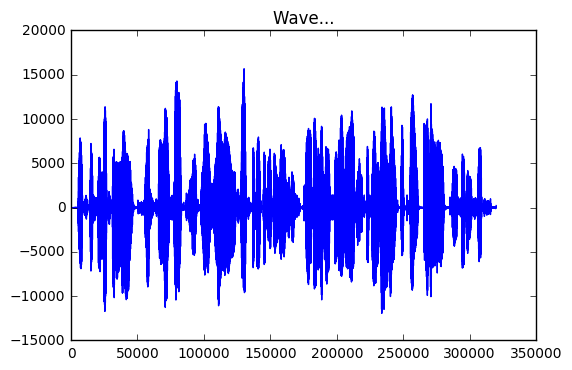

In [518]:
spf = wave.open('/Users/drbh/speaker_detection/stream.wav','r')
fs = spf.getframerate()
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')
# subst_wav(fs,signal,0,10)
for i in range(100):
    plt.gca().cla() 
    sub_and_plot(fs,signal,i*10000,10)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.05)
display.clear_output(wait=True)

In [ ]:
def sum(a, b):
    return a + b

values = (1, 2)

s = sum(*values)

In [ ]:
read_wav("")

In [ ]:
test_model(mods,path="/Users/drbh/speaker_detection/stream.wav")

In [442]:
!ls -lah ./People/David

total 39080
drwxr-xr-x  22 drbh  staff   748B Dec 28 21:41 .
drwxr-xr-x   8 drbh  staff   272B Dec 28 21:39 ..
-rw-r--r--@  1 drbh  staff   6.0K Dec 28 21:40 .DS_Store
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:40 20161228-214054.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214057.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214100.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214103.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214106.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214109.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214113.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214116.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214119.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214122.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214125.wav
-rw-r--r--   1 drbh  staff   1.0M Dec 28 21:41 20161228-214128.wav
-rw-r--r--   1 drbh  staff  

-1.0
-0.0155403348554
1.0


In [321]:
import operator

def test(fs,signal,model):
    mods = model
    feat = mix_feature((fs, signal))
    x = feat
    scores = [mods.gmmset.gmm_score(gmm, x) / len(x) for gmm in mods.gmmset.gmms]
    p = sorted(enumerate(scores), key=operator.itemgetter(1), reverse=True)
    p = [(str(mods.gmmset.y[i]), y, p[0][1] - y) for i, y in p]
    result = [(mods.gmmset.y[index], value) for (index, value) in enumerate(scores)]
    p = max(result, key=operator.itemgetter(1))
    
    return p#,feat.min(),feat.mean(),feat.max()

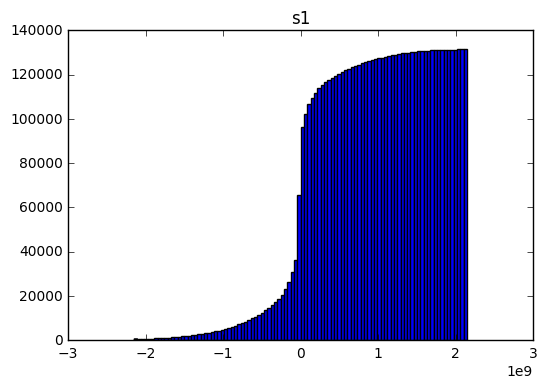

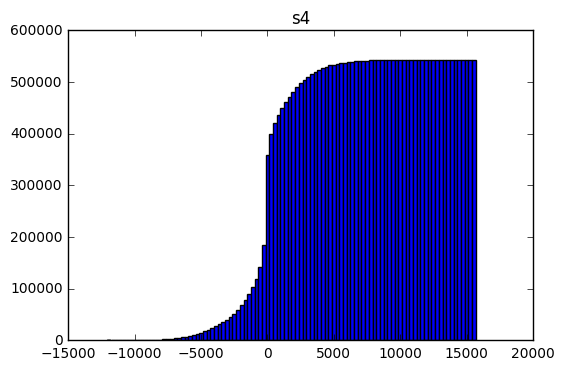

In [126]:
plt.hist(s1,bins=100,cumulative=True)
plt.title("s1")
# plt.hist(s2,bins=100)
# plt.hist(s3,bins=100)
plt.figure()
plt.hist(s4,bins=100,cumulative=True)
plt.title("s4")

In [180]:
def nomalize_wav(signal):
    signal = signal / 2**15
    print signal.min()
    print signal.mean()
    print signal.max()
    return signal

s1.min(),s1.mean(),s1.max()

(-2147483648, -10255427.256354643, 2147093246)

In [240]:
from sklearn.preprocessing import normalize

x = np.random.rand(1000)*10
norm2 = normalize(x[:,np.newaxis], axis=1).ravel()
print norm2

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [203]:
np.newaxis

In [199]:
e1 = x / np.linalg.norm(s1)

In [225]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

# Testings Normalization

In [448]:
def nmlz(s):
    signal = normalize(s[:,np.newaxis], axis=1).ravel()
    return signal

In [503]:
f1, s1 = read_wav("/Users/drbh/speaker_detection/People/David/20161228-214054.wav")
f2, s2 = read_wav("/Users/drbh/speaker_detection/People/Kathy/20161228-202007.wav")
f3, s3 = read_wav("/Users/drbh/speaker_detection/People/David/20161228-214119.wav")
f4, s4 = read_wav("/Users/drbh/speaker_detection/stream.wav")

In [504]:
e1 = nmlz(s1 * 3)

e2 = nmlz(s2 * 3)

e3 = nmlz(s3 * 3)

e4 = nmlz(s4[:131400] * 3)


In [505]:
abc = ModelInterface()
for p in ["/Users/drbh/speaker_detection/People/David/20161228-214141.wav",
        "/Users/drbh/speaker_detection/People/David/20161228-214119.wav"]:
    print p
    fs, signal = read_wav(p)
    # fs, signal = read_wav("/Users/drbh/speaker_detection/People/David/20161228-214119.wav")
    fs, signal = check_vad(fs, signal * 3 )
    signal = nmlz(signal)
    abc.enroll("ME", fs, signal)
abc.train()

/Users/drbh/speaker_detection/People/David/20161228-214141.wav
[(5120, 124928)] 130048
After removed: 131400 -> 119808
Enroll: 2.7167 seconds
/Users/drbh/speaker_detection/People/David/20161228-214119.wav
[(5120, 124928)] 130048
After removed: 131400 -> 119808
Enroll: 2.7167 seconds
Start training...
0.029196023941  seconds


In [506]:
xyz = ModelInterface()
fs, signal = read_wav("/Users/drbh/speaker_detection/stream.wav")
# fs, signal = read_wav("/Users/drbh/speaker_detection/People/David/20161228-214119.wav")
fs, signal = check_vad(fs, signal[:131400] * 3 )
signal = nmlz(signal)
xyz.enroll("Unknown", fs, signal)
xyz.train()

[(5120, 48128), (51200, 92160), (93184, 124928)] 130048
After removed: 131400 -> 115712
Enroll: 3.6160 seconds
Start training...
0.0430090427399  seconds


In [507]:
print "ABC - ME"
print "nmlz   ME", test(f1, e1, abc), test(f1, e1, abc)[1] > -.2
print "nmlz   KATHY", test(f2, e2, abc), test(f2, e2, abc)[1] > -.2
print "nmlz   ME", test(f3, e3, abc), test(f3, e3, abc)[1] > -.2
print "nmlz   STREAM", test(f4, e4, abc), test(f4, e4, abc)[1] > -.2
print "   "
print "XYZ - STREAM"
print "nmlz   ME", test(f1, e1, xyz), test(f1, e1, xyz)[1] > -.2
print "nmlz   KATHY", test(f2, e2, xyz), test(f2, e2, xyz)[1] > -.2
print "nmlz   ME", test(f3, e3, xyz), test(f3, e3, xyz)[1] > -.2
print "nmlz   STREAM", test(f4, e4, xyz), test(f4, e4, xyz)[1] > -.2

ABC - ME
nmlz   ME ('ME', -54.603023764029736) False
nmlz   KATHY ('ME', -60.837492383085326) False
nmlz   ME ('ME', -44.412438781513863) False
nmlz   STREAM ('ME', -35.349377026399111) False
   
XYZ - STREAM
nmlz   ME ('Unknown', -389.94760256319375) False
nmlz   KATHY ('Unknown', -374.28688609700481) False
nmlz   ME ('Unknown', -148.68234622983505) False
nmlz   STREAM ('Unknown', -64.884644569479434) False


In [508]:
# mods = mods.load("./model.out")
see_model(abc)

1 ME 336


In [509]:
see_model(xyz)

1 Unknown 225


In [1]:
help("modules")


Please wait a moment while I gather a list of all available modules...



/Users/drbh/speak/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/Users/drbh/speak/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Audio_mac           _ssl                gestalt             random
BaseHTTPServer      _strptime           getopt              re
Bastion             _struct             getpass             readline
CGIHTTPServer       _symtable           gettext             repr
Canvas              _sysconfigdata      glob                requests
Carbon              _testcapi           grp                 resource
CodeWarrior         _threading_local    gzip                rexec
ColorPicker         _tkinter            hashlib             rfc822
ConfigParser        _warnings           heapq               rlcompleter
Cookie              _weakref            hmac                rmagic
Dialog              _weakrefset         hotshot             robotparser
DocXMLRPCServer     abc                 htmlentitydefs      runpy
EasyDialogs         aepack              htmllib             sched
Explorer            aetools             httplib             scikits
FileDialog          aetypes             ic            